In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import sys
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline
!pip install timm 
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
from torch.nn import CrossEntropyLoss
import warnings
warnings.filterwarnings("ignore")
!pip install split-folders
import splitfolders
!pip install opencv-python
import cv2
from PIL import Image
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ec315581568d476f2898689d5ba0f2e09193816239378fa0ce47c8fcba8ef8dd
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab

In [2]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
PROJECT = 'homework2_ML'
DATA_DIR = 'data'
ARTIFACT_PATH = '/content/w&b/'

#Utilities for dataset manipulation

In [4]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [5]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
dataset_path_original = "/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/Dataset"
splitfolders.ratio(dataset_path_original, output="dataset_", seed=1337, ratio=(.8, 0.1,0.1)) 
classes = get_classes('/content/dataset_/train/')
print("Found : ",len(classes),"classes --->>>",classes)

Copying files: 2911 files [00:34, 83.46 files/s] 

Found :  10 classes --->>> ['Balcony', 'Bathroom', 'Bedroom', 'Fireplace', 'Garden', 'Hammok', 'Kitchen', 'Panoramic_view', 'Pool', 'Stairs']


In [8]:
dataset_path = "/content/dataset_"
batch_size = 32
training_batch_size = 128

In [9]:
#Rename the folder val in /dataset_ from val to valid
(train_loader, train_data_len) = get_data_loaders(dataset_path, training_batch_size , train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, batch_size=batch_size, train=False)

In [10]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [12]:
print("Batch size (val) = ", batch_size)
print("Batch size (training) = ", training_batch_size)
print("Batches per training: ", len(train_loader))
print("Batches per validation: ", len(val_loader))
print("Batches per test: ", len (test_loader) )

Batch size (val) =  32
Batch size (training) =  128
Batches per training:  19
Batches per validation:  9
Batches per test:  10


In [11]:
print(train_data_len, valid_data_len, test_data_len)

2324 287 300


#Log dati a Wandb

Log alcune immagini del dataset

In [ ]:
wandb.init(project=PROJECT , job_type="log_dataset")
table = wandb.Table(columns=["image", "label"])
for step, (img, label) in enumerate(tqdm(train_loader, leave=False)):
    w_img = wandb.Image(np.transpose(img[0].numpy(), axes=(1,2,0)))
    table.add_data(w_img, classes[label.numpy()[0]])
    if step == 10: 
        break


wandb.log({'train_data/train_table':table})
wandb.finish()

Log distribuzione dei batches

In [ ]:
from collections import Counter
dat = datasets.ImageFolder(dataset_path_original)
classes = []
distrib = {}

for item in dat.class_to_idx.keys():
  classes.append(item)

for i,item in enumerate(dict(Counter(dat.targets)).values()):
  distrib[classes[i]] = item

distrib

In [ ]:
wandb.init(project=PROJECT , job_type="dataset_distribution")
wandb.log({'data_distrib': distrib})
wandb.finish()

#Scelta del Modello

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Flying on the ->",device)

Flying on the -> cuda


In [21]:
config = {
    # "learning_rate": 0.001, #head 1
    "learning_rate": 0.01, #head 2
    "num_epochs": 300,
    "batch_size": 32,
    "training_batch_size": 128,
    "img_size": (224, 224, 3),
    #'backbone': 'efficientNet_head1'
    'backbone': 'deit'
}

In [22]:
LR = config['learning_rate']
EPOCHS = config['num_epochs']

# Log the final results on the validation set
LOG_IMAGES = True
LOG_CONFUSION_MATRIX = True





In [20]:
def build_model(num_classes=10, backbone='deit'):
    if backbone == 'deit':
      model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
      for param in model.parameters(): #freeze model
        param.requires_grad = False

      n_inputs = model.head.in_features
      model.head = nn.Sequential(
          nn.Linear(n_inputs, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, len(classes))
      )
      model = model.to(device)
    
    if backbone == 'efficientNet_head1':
      model = EfficientNet.from_pretrained('efficientnet-b0')
      n_inputs = 1000 #output class di efficientnet
      model.head = nn.Sequential(
          nn.Linear(n_inputs, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, len(classes))
      )
      model = model.to(device)
    
    if backbone == 'efficientNet_head2':
      model = EfficientNet.from_pretrained('efficientnet-b0')
      n_inputs = 1000 #output class di efficientnet
      model.head = nn.Sequential(
          nn.BatchNorm1d(1000),
          nn.Linear(1000, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(256, len(classes))
      )
      model = model.to(device)

      
    return model


#TEST modello prima del finetuning


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()
wandb.init(project=PROJECT , job_type="log_test_efficientNet")

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        print(data.shape)
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
        wandb.log({'Test Accuracy '+classes[i] : 100*class_correct[i]/class_total[i]})
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))


wandb.finish()

#Costruzione modello

In [21]:
model = build_model(backbone=config['backbone'])
optimizer = optim.Adam(model.parameters(), config['learning_rate'])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [14]:
#Loss defining
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)

In [23]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

Inizializzazione Wandb

In [24]:
wandb.init(project=PROJECT, sync_tensorboard=True, job_type='training_logs')
wandb.config.update(config)

wandb: Currently logged in as: rucci-2053183 (sapienza_ml_2022_23). Use `wandb login --relogin` to force relogin


In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=config['num_epochs'],callbacks=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    wandb.watch(model, log_freq=10)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            if epoch % 10 == 0: #ogi 10 epoche printo su wandb
              wandb.log({phase+"_loss": epoch_loss})
              wandb.log({phase+"_acc": epoch_acc})
              wandb.log({"learning_rate_EfficientNet_B0_head2": optimizer.param_groups[0]["lr"]})

            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,callbacks=None)
wandb.finish()

Epoch 0/299
----------


100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


train Loss: 3.2437 Acc: 0.4032


100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


val Loss: 138047.2211 Acc: 0.1150

Epoch 1/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


train Loss: 2.2679 Acc: 0.5357


100%|██████████| 9/9 [00:01<00:00,  5.00it/s]


val Loss: 24822.7679 Acc: 0.1115

Epoch 2/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.9958 Acc: 0.6528


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


val Loss: 1023.0085 Acc: 0.1324

Epoch 3/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.8478 Acc: 0.7014


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


val Loss: 207.5565 Acc: 0.1115

Epoch 4/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.8292 Acc: 0.7057


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


val Loss: 24.2910 Acc: 0.1498

Epoch 5/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.7689 Acc: 0.7427


100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


val Loss: 14.7243 Acc: 0.1672

Epoch 6/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.6852 Acc: 0.7642


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 7.8255 Acc: 0.2892

Epoch 7/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.6531 Acc: 0.7836


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 6.4452 Acc: 0.3380

Epoch 8/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.5875 Acc: 0.7965


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


val Loss: 8.5403 Acc: 0.2369

Epoch 9/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.5369 Acc: 0.8188


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


val Loss: 10.3563 Acc: 0.1742

Epoch 10/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


train Loss: 1.5613 Acc: 0.8120


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


val Loss: 8.0033 Acc: 0.2927

Epoch 11/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.4645 Acc: 0.8559


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


val Loss: 5.2136 Acc: 0.3031

Epoch 12/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.4663 Acc: 0.8498


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


val Loss: 4.7997 Acc: 0.3659

Epoch 13/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.4597 Acc: 0.8507


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 5.9453 Acc: 0.2056

Epoch 14/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.4132 Acc: 0.8649


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 4.0391 Acc: 0.3902

Epoch 15/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.4459 Acc: 0.8632


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


val Loss: 4.1376 Acc: 0.4530

Epoch 16/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.3983 Acc: 0.8804


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 7.2266 Acc: 0.3589

Epoch 17/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.4260 Acc: 0.8640


100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


val Loss: 3.9575 Acc: 0.5087

Epoch 18/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.3268 Acc: 0.9040


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


val Loss: 3.7730 Acc: 0.5923

Epoch 19/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.2363 Acc: 0.9299


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 3.4101 Acc: 0.5470

Epoch 20/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.3179 Acc: 0.8997


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


val Loss: 3.0167 Acc: 0.5540

Epoch 21/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.3098 Acc: 0.9053


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


val Loss: 3.3956 Acc: 0.5645

Epoch 22/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.3034 Acc: 0.9139


100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


val Loss: 3.6945 Acc: 0.5192

Epoch 23/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.2876 Acc: 0.9182


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 7.8470 Acc: 0.3868

Epoch 24/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.2565 Acc: 0.9230


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 5.5728 Acc: 0.3659

Epoch 25/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.2957 Acc: 0.9049


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


val Loss: 4.3085 Acc: 0.4286

Epoch 26/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.2578 Acc: 0.9294


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


val Loss: 3.3947 Acc: 0.5261

Epoch 27/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.2455 Acc: 0.9333


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


val Loss: 2.9776 Acc: 0.5470

Epoch 28/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.2118 Acc: 0.9398


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


val Loss: 2.8198 Acc: 0.6028

Epoch 29/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.2197 Acc: 0.9449


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 2.7488 Acc: 0.6272

Epoch 30/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1794 Acc: 0.9514


100%|██████████| 9/9 [00:02<00:00,  4.45it/s]


val Loss: 3.0774 Acc: 0.6063

Epoch 31/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.1652 Acc: 0.9608


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 2.3450 Acc: 0.6899

Epoch 32/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1450 Acc: 0.9639


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 2.3517 Acc: 0.7003

Epoch 33/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.1891 Acc: 0.9492


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 2.7376 Acc: 0.6516

Epoch 34/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1992 Acc: 0.9505


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


val Loss: 3.2882 Acc: 0.6620

Epoch 35/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1785 Acc: 0.9596


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 2.1930 Acc: 0.7422

Epoch 36/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.1952 Acc: 0.9475


100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


val Loss: 2.6444 Acc: 0.6760

Epoch 37/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1512 Acc: 0.9621


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


val Loss: 2.4668 Acc: 0.6690

Epoch 38/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.2120 Acc: 0.9449


100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


val Loss: 3.0890 Acc: 0.5958

Epoch 39/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.1753 Acc: 0.9518


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


val Loss: 2.9817 Acc: 0.5958

Epoch 40/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1430 Acc: 0.9639


100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


val Loss: 2.4805 Acc: 0.6341

Epoch 41/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.1178 Acc: 0.9703


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


val Loss: 2.4790 Acc: 0.6690

Epoch 42/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1518 Acc: 0.9626


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 2.7169 Acc: 0.6307

Epoch 43/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1166 Acc: 0.9725


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 2.4090 Acc: 0.7352

Epoch 44/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.1282 Acc: 0.9673


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


val Loss: 3.1382 Acc: 0.6028

Epoch 45/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1543 Acc: 0.9596


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 2.1745 Acc: 0.7422

Epoch 46/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.1527 Acc: 0.9613


100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


val Loss: 2.0273 Acc: 0.7596

Epoch 47/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


train Loss: 1.1767 Acc: 0.9544


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 2.4944 Acc: 0.6307

Epoch 48/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1620 Acc: 0.9540


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


val Loss: 2.2989 Acc: 0.7247

Epoch 49/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.1293 Acc: 0.9660


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 2.2487 Acc: 0.7143

Epoch 50/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0969 Acc: 0.9755


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


val Loss: 2.1590 Acc: 0.7491

Epoch 51/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0957 Acc: 0.9785


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


val Loss: 2.2441 Acc: 0.7213

Epoch 52/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1058 Acc: 0.9789


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 2.1024 Acc: 0.7422

Epoch 53/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1127 Acc: 0.9716


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


val Loss: 2.0710 Acc: 0.7317

Epoch 54/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1187 Acc: 0.9725


100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


val Loss: 2.0870 Acc: 0.7456

Epoch 55/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.1298 Acc: 0.9682


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 2.4262 Acc: 0.6794

Epoch 56/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.1145 Acc: 0.9729


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 2.1941 Acc: 0.7631

Epoch 57/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0883 Acc: 0.9811


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.9816 Acc: 0.7735

Epoch 58/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1095 Acc: 0.9759


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 2.3079 Acc: 0.7213

Epoch 59/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0872 Acc: 0.9824


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 2.1963 Acc: 0.7143

Epoch 60/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0865 Acc: 0.9845


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


val Loss: 2.1520 Acc: 0.7282

Epoch 61/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0720 Acc: 0.9858


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.9746 Acc: 0.7526

Epoch 62/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0698 Acc: 0.9871


100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


val Loss: 1.9332 Acc: 0.7700

Epoch 63/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


train Loss: 1.0607 Acc: 0.9880


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


val Loss: 1.9340 Acc: 0.7596

Epoch 64/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0585 Acc: 0.9905


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 1.9266 Acc: 0.7805

Epoch 65/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0702 Acc: 0.9862


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.9443 Acc: 0.7561

Epoch 66/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0738 Acc: 0.9845


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 2.1520 Acc: 0.7178

Epoch 67/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0969 Acc: 0.9763


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 2.0382 Acc: 0.7770

Epoch 68/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1057 Acc: 0.9776


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


val Loss: 2.0656 Acc: 0.7561

Epoch 69/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0910 Acc: 0.9772


100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


val Loss: 2.2125 Acc: 0.7456

Epoch 70/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0981 Acc: 0.9781


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


val Loss: 1.9509 Acc: 0.7805

Epoch 71/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


train Loss: 1.0992 Acc: 0.9746


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


val Loss: 2.1825 Acc: 0.7213

Epoch 72/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1151 Acc: 0.9694


100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


val Loss: 2.0281 Acc: 0.7666

Epoch 73/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0776 Acc: 0.9858


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 2.0073 Acc: 0.7700

Epoch 74/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.1543 Acc: 0.9544


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 2.7400 Acc: 0.6551

Epoch 75/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0981 Acc: 0.9785


100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


val Loss: 2.2943 Acc: 0.6829

Epoch 76/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.1089 Acc: 0.9759


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 2.1711 Acc: 0.7631

Epoch 77/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0849 Acc: 0.9811


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 2.0349 Acc: 0.7596

Epoch 78/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0617 Acc: 0.9884


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


val Loss: 1.8427 Acc: 0.7805

Epoch 79/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0508 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.9097 Acc: 0.7666

Epoch 80/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0736 Acc: 0.9836


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


val Loss: 1.8436 Acc: 0.7805

Epoch 81/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0665 Acc: 0.9880


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


val Loss: 1.8567 Acc: 0.7875

Epoch 82/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0991 Acc: 0.9712


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 2.1633 Acc: 0.7178

Epoch 83/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.1005 Acc: 0.9733


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 2.0661 Acc: 0.7247

Epoch 84/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0740 Acc: 0.9845


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 2.0846 Acc: 0.7526

Epoch 85/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0647 Acc: 0.9875


100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


val Loss: 1.9047 Acc: 0.7979

Epoch 86/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0777 Acc: 0.9824


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


val Loss: 1.9537 Acc: 0.7352

Epoch 87/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0638 Acc: 0.9880


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.9877 Acc: 0.7526

Epoch 88/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0635 Acc: 0.9880


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 2.0174 Acc: 0.7352

Epoch 89/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0524 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.9003 Acc: 0.7700

Epoch 90/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0527 Acc: 0.9918


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


val Loss: 1.9755 Acc: 0.7805

Epoch 91/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0522 Acc: 0.9910


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.9633 Acc: 0.7352

Epoch 92/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0876 Acc: 0.9776


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


val Loss: 2.3115 Acc: 0.6864

Epoch 93/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0892 Acc: 0.9793


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 2.3837 Acc: 0.7038

Epoch 94/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0697 Acc: 0.9871


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


val Loss: 2.1187 Acc: 0.7317

Epoch 95/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0530 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.9222 Acc: 0.7805

Epoch 96/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0472 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.9581 Acc: 0.7840

Epoch 97/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0538 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


val Loss: 2.0195 Acc: 0.7735

Epoch 98/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0412 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 2.0296 Acc: 0.7456

Epoch 99/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0426 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.8550 Acc: 0.7561

Epoch 100/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0401 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


val Loss: 1.8203 Acc: 0.7840

Epoch 101/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0416 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.7881 Acc: 0.7979

Epoch 102/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0390 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.7730 Acc: 0.8223

Epoch 103/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0496 Acc: 0.9918


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


val Loss: 1.8185 Acc: 0.8014

Epoch 104/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0411 Acc: 0.9931


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.8404 Acc: 0.7979

Epoch 105/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0400 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.7798 Acc: 0.8188

Epoch 106/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0507 Acc: 0.9892


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


val Loss: 1.8341 Acc: 0.7909

Epoch 107/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0391 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.8046 Acc: 0.8188

Epoch 108/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0354 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


val Loss: 1.7981 Acc: 0.8084

Epoch 109/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0315 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


val Loss: 1.7347 Acc: 0.8258

Epoch 110/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0369 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


val Loss: 1.8534 Acc: 0.7909

Epoch 111/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0457 Acc: 0.9918


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 2.0745 Acc: 0.7631

Epoch 112/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0658 Acc: 0.9862


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.9700 Acc: 0.7700

Epoch 113/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0552 Acc: 0.9892


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.8995 Acc: 0.7805

Epoch 114/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0507 Acc: 0.9905


100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


val Loss: 2.0811 Acc: 0.7387

Epoch 115/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0464 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.9599 Acc: 0.7666

Epoch 116/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0406 Acc: 0.9931


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.8064 Acc: 0.7979

Epoch 117/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0514 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


val Loss: 1.8203 Acc: 0.8153

Epoch 118/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.0639 Acc: 0.9867


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.9534 Acc: 0.7770

Epoch 119/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0442 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.8757 Acc: 0.7735

Epoch 120/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0479 Acc: 0.9910


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


val Loss: 1.8929 Acc: 0.7944

Epoch 121/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0380 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8122 Acc: 0.8188

Epoch 122/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0538 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.8452 Acc: 0.8049

Epoch 123/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0476 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.8687 Acc: 0.7840

Epoch 124/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0505 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.8810 Acc: 0.7735

Epoch 125/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0562 Acc: 0.9892


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


val Loss: 1.8980 Acc: 0.7875

Epoch 126/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


train Loss: 1.0574 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


val Loss: 1.8924 Acc: 0.7805

Epoch 127/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0544 Acc: 0.9905


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.8879 Acc: 0.7805

Epoch 128/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0391 Acc: 0.9940


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


val Loss: 1.8069 Acc: 0.8014

Epoch 129/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0587 Acc: 0.9897


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 2.1058 Acc: 0.7666

Epoch 130/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0623 Acc: 0.9875


100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


val Loss: 1.9580 Acc: 0.7979

Epoch 131/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0546 Acc: 0.9905


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 1.9296 Acc: 0.7875

Epoch 132/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0503 Acc: 0.9918


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.8619 Acc: 0.7979

Epoch 133/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0407 Acc: 0.9944


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


val Loss: 1.7482 Acc: 0.8118

Epoch 134/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0668 Acc: 0.9871


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.8870 Acc: 0.7979

Epoch 135/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0534 Acc: 0.9884


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.7798 Acc: 0.8258

Epoch 136/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0421 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 1.7339 Acc: 0.8223

Epoch 137/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0489 Acc: 0.9923


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.7670 Acc: 0.8223

Epoch 138/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0405 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.7492 Acc: 0.8397

Epoch 139/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0424 Acc: 0.9940


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.7397 Acc: 0.8258

Epoch 140/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


train Loss: 1.0592 Acc: 0.9858


100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


val Loss: 1.8828 Acc: 0.7770

Epoch 141/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0735 Acc: 0.9862


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 2.1444 Acc: 0.7213

Epoch 142/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0597 Acc: 0.9892


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.9527 Acc: 0.7770

Epoch 143/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0656 Acc: 0.9892


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.9734 Acc: 0.7631

Epoch 144/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0492 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


val Loss: 1.8763 Acc: 0.7700

Epoch 145/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0429 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.9100 Acc: 0.7805

Epoch 146/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0358 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.9077 Acc: 0.7944

Epoch 147/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0361 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.8603 Acc: 0.7909

Epoch 148/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0356 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.8558 Acc: 0.8153

Epoch 149/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0388 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


val Loss: 1.9342 Acc: 0.7561

Epoch 150/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0345 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


val Loss: 1.9378 Acc: 0.7596

Epoch 151/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0384 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.9386 Acc: 0.7875

Epoch 152/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0367 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.7937 Acc: 0.8084

Epoch 153/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0410 Acc: 0.9940


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 1.7431 Acc: 0.8014

Epoch 154/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0351 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.8641 Acc: 0.8084

Epoch 155/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0383 Acc: 0.9940


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


val Loss: 1.7240 Acc: 0.8293

Epoch 156/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0338 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.8195 Acc: 0.8188

Epoch 157/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.0391 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


val Loss: 1.8335 Acc: 0.7944

Epoch 158/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0501 Acc: 0.9905


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.7952 Acc: 0.8084

Epoch 159/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0377 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.7716 Acc: 0.7875

Epoch 160/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0337 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


val Loss: 1.7212 Acc: 0.8223

Epoch 161/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0347 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


val Loss: 1.7446 Acc: 0.7944

Epoch 162/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0365 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.8507 Acc: 0.7875

Epoch 163/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0499 Acc: 0.9901


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.9027 Acc: 0.7840

Epoch 164/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0461 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


val Loss: 1.8413 Acc: 0.7909

Epoch 165/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


train Loss: 1.0427 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


val Loss: 2.0345 Acc: 0.7456

Epoch 166/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0339 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8728 Acc: 0.7805

Epoch 167/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0478 Acc: 0.9910


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8817 Acc: 0.7840

Epoch 168/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0452 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


val Loss: 1.8039 Acc: 0.7909

Epoch 169/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0446 Acc: 0.9935


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.8195 Acc: 0.7944

Epoch 170/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0546 Acc: 0.9914


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


val Loss: 1.8824 Acc: 0.7700

Epoch 171/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0395 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


val Loss: 1.9285 Acc: 0.7666

Epoch 172/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0346 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.7913 Acc: 0.7944

Epoch 173/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0319 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


val Loss: 1.7632 Acc: 0.7875

Epoch 174/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0322 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 1.7510 Acc: 0.7944

Epoch 175/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0343 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


val Loss: 1.7730 Acc: 0.7875

Epoch 176/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0363 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


val Loss: 2.0684 Acc: 0.7491

Epoch 177/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0352 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.9724 Acc: 0.7666

Epoch 178/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0397 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


val Loss: 1.8644 Acc: 0.7979

Epoch 179/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0414 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.9173 Acc: 0.7805

Epoch 180/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0401 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


val Loss: 1.9057 Acc: 0.7944

Epoch 181/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0392 Acc: 0.9940


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.8250 Acc: 0.8153

Epoch 182/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0334 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


val Loss: 1.8461 Acc: 0.7944

Epoch 183/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0381 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.7960 Acc: 0.8084

Epoch 184/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0314 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


val Loss: 1.7781 Acc: 0.8293

Epoch 185/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0294 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


val Loss: 1.7949 Acc: 0.8153

Epoch 186/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0313 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.9031 Acc: 0.7875

Epoch 187/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0290 Acc: 0.9987


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


val Loss: 1.8791 Acc: 0.8014

Epoch 188/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0321 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


val Loss: 1.8993 Acc: 0.8014

Epoch 189/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0323 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


val Loss: 1.8687 Acc: 0.8293

Epoch 190/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0337 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


val Loss: 1.8305 Acc: 0.8258

Epoch 191/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0339 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


val Loss: 1.8359 Acc: 0.8188

Epoch 192/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0320 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.8350 Acc: 0.7805

Epoch 193/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0283 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


val Loss: 1.8416 Acc: 0.7875

Epoch 194/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0321 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


val Loss: 1.8384 Acc: 0.8049

Epoch 195/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0310 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8345 Acc: 0.8153

Epoch 196/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0329 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.8548 Acc: 0.8049

Epoch 197/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0409 Acc: 0.9923


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.8846 Acc: 0.7979

Epoch 198/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0345 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8218 Acc: 0.8118

Epoch 199/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0310 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.7990 Acc: 0.8153

Epoch 200/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0297 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


val Loss: 1.9276 Acc: 0.7805

Epoch 201/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0329 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 1.8496 Acc: 0.8049

Epoch 202/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0278 Acc: 0.9970


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


val Loss: 1.8126 Acc: 0.8014

Epoch 203/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


train Loss: 1.0251 Acc: 0.9996


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.7756 Acc: 0.8223

Epoch 204/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0283 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


val Loss: 1.7894 Acc: 0.8293

Epoch 205/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0242 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


val Loss: 1.9295 Acc: 0.7805

Epoch 206/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0275 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


val Loss: 1.9707 Acc: 0.7700

Epoch 207/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0277 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


val Loss: 1.9567 Acc: 0.7735

Epoch 208/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0263 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


val Loss: 1.8785 Acc: 0.7770

Epoch 209/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0267 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.8480 Acc: 0.7979

Epoch 210/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0256 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


val Loss: 1.8409 Acc: 0.8188

Epoch 211/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0258 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.8249 Acc: 0.8328

Epoch 212/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0290 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.8126 Acc: 0.8258

Epoch 213/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0296 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


val Loss: 1.8468 Acc: 0.8118

Epoch 214/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0308 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 1.9714 Acc: 0.7805

Epoch 215/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0310 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.9057 Acc: 0.7770

Epoch 216/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0296 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.8938 Acc: 0.7909

Epoch 217/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0337 Acc: 0.9957


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


val Loss: 1.8563 Acc: 0.7979

Epoch 218/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0309 Acc: 0.9961


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.8474 Acc: 0.8049

Epoch 219/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0332 Acc: 0.9957


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 1.8246 Acc: 0.8223

Epoch 220/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0284 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


val Loss: 1.8091 Acc: 0.8188

Epoch 221/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0293 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


val Loss: 1.8279 Acc: 0.8118

Epoch 222/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0415 Acc: 0.9927


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


val Loss: 2.0772 Acc: 0.7666

Epoch 223/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0362 Acc: 0.9944


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.9676 Acc: 0.7770

Epoch 224/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0352 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


val Loss: 1.9307 Acc: 0.7944

Epoch 225/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


train Loss: 1.0279 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.8110 Acc: 0.8258

Epoch 226/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0250 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.7931 Acc: 0.8328

Epoch 227/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0301 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


val Loss: 1.7979 Acc: 0.8397

Epoch 228/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0251 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


val Loss: 1.8121 Acc: 0.8153

Epoch 229/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0271 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.8008 Acc: 0.8084

Epoch 230/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0254 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.38it/s]


val Loss: 1.7788 Acc: 0.8188

Epoch 231/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0254 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


val Loss: 1.7987 Acc: 0.8188

Epoch 232/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0234 Acc: 0.9996


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.7889 Acc: 0.8118

Epoch 233/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0241 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 1.7853 Acc: 0.8153

Epoch 234/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0345 Acc: 0.9948


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


val Loss: 1.8218 Acc: 0.8223

Epoch 235/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0279 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


val Loss: 1.8297 Acc: 0.8188

Epoch 236/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0260 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


val Loss: 1.7981 Acc: 0.8223

Epoch 237/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0303 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


val Loss: 1.8870 Acc: 0.8049

Epoch 238/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0276 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


val Loss: 1.8608 Acc: 0.7805

Epoch 239/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0281 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.8380 Acc: 0.7875

Epoch 240/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0345 Acc: 0.9953


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


val Loss: 1.7663 Acc: 0.8014

Epoch 241/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0274 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


val Loss: 1.7579 Acc: 0.8153

Epoch 242/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0245 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.7585 Acc: 0.8223

Epoch 243/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0257 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.7880 Acc: 0.8223

Epoch 244/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0264 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


val Loss: 1.7919 Acc: 0.8223

Epoch 245/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0235 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.8333 Acc: 0.8153

Epoch 246/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0256 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


val Loss: 1.8557 Acc: 0.8084

Epoch 247/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0260 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


val Loss: 1.8274 Acc: 0.8084

Epoch 248/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0225 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.8363 Acc: 0.8084

Epoch 249/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0271 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


val Loss: 1.8381 Acc: 0.8188

Epoch 250/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0272 Acc: 0.9978


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


val Loss: 1.8130 Acc: 0.8153

Epoch 251/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


train Loss: 1.0265 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.8049 Acc: 0.8153

Epoch 252/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0262 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


val Loss: 1.7952 Acc: 0.8153

Epoch 253/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0243 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.7972 Acc: 0.8153

Epoch 254/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0244 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


val Loss: 1.7953 Acc: 0.8223

Epoch 255/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]


train Loss: 1.0250 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.7890 Acc: 0.8188

Epoch 256/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0256 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.7612 Acc: 0.8293

Epoch 257/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0279 Acc: 0.9966


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


val Loss: 1.8191 Acc: 0.8188

Epoch 258/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0249 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


val Loss: 1.8160 Acc: 0.8223

Epoch 259/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0317 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


val Loss: 1.8100 Acc: 0.8293

Epoch 260/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0264 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


val Loss: 1.7904 Acc: 0.8293

Epoch 261/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


train Loss: 1.0222 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


val Loss: 1.7801 Acc: 0.8258

Epoch 262/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.05s/it]


train Loss: 1.0254 Acc: 0.9974


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


val Loss: 1.7788 Acc: 0.8293

Epoch 263/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.0229 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


val Loss: 1.7672 Acc: 0.8293

Epoch 264/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0265 Acc: 0.9966


100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


val Loss: 1.7727 Acc: 0.8328

Epoch 265/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0211 Acc: 0.9996


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


val Loss: 1.7733 Acc: 0.8362

Epoch 266/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0227 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


val Loss: 1.7608 Acc: 0.8362

Epoch 267/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0225 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


val Loss: 1.7645 Acc: 0.8293

Epoch 268/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0257 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


val Loss: 1.7681 Acc: 0.8293

Epoch 269/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0232 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


val Loss: 1.7902 Acc: 0.8258

Epoch 270/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


train Loss: 1.0227 Acc: 1.0000


100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


val Loss: 1.8472 Acc: 0.8153

Epoch 271/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0237 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.8252 Acc: 0.8084

Epoch 272/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.05s/it]


train Loss: 1.0228 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.7891 Acc: 0.8258

Epoch 273/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0229 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


val Loss: 1.7840 Acc: 0.8223

Epoch 274/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0237 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.7950 Acc: 0.8188

Epoch 275/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0223 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


val Loss: 1.7999 Acc: 0.8188

Epoch 276/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0264 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


val Loss: 1.8541 Acc: 0.8049

Epoch 277/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


train Loss: 1.0288 Acc: 0.9970


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


val Loss: 1.8146 Acc: 0.8118

Epoch 278/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.02s/it]


train Loss: 1.0228 Acc: 0.9991


100%|██████████| 9/9 [00:02<00:00,  3.75it/s]


val Loss: 1.7994 Acc: 0.8188

Epoch 279/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


train Loss: 1.0238 Acc: 0.9978


100%|██████████| 9/9 [00:02<00:00,  3.84it/s]


val Loss: 1.7682 Acc: 0.8362

Epoch 280/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


train Loss: 1.0282 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.38it/s]


val Loss: 1.8039 Acc: 0.8293

Epoch 281/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0268 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


val Loss: 1.8036 Acc: 0.8223

Epoch 282/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0230 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


val Loss: 1.8118 Acc: 0.8188

Epoch 283/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0234 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


val Loss: 1.7964 Acc: 0.8223

Epoch 284/299
----------


100%|██████████| 19/19 [00:20<00:00,  1.05s/it]


train Loss: 1.0238 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


val Loss: 1.7845 Acc: 0.8397

Epoch 285/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0221 Acc: 0.9996


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


val Loss: 1.7765 Acc: 0.8397

Epoch 286/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


train Loss: 1.0261 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


val Loss: 1.7529 Acc: 0.8258

Epoch 287/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


train Loss: 1.0225 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


val Loss: 1.7460 Acc: 0.8258

Epoch 288/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0232 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


val Loss: 1.7463 Acc: 0.8258

Epoch 289/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0245 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


val Loss: 1.8158 Acc: 0.8049

Epoch 290/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


train Loss: 1.0254 Acc: 0.9978


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


val Loss: 1.8052 Acc: 0.8153

Epoch 291/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.04s/it]


train Loss: 1.0229 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


val Loss: 1.7979 Acc: 0.8188

Epoch 292/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


train Loss: 1.0234 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


val Loss: 1.8305 Acc: 0.8014

Epoch 293/299
----------


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


train Loss: 1.0241 Acc: 0.9987


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


val Loss: 1.8322 Acc: 0.8084

Epoch 294/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0279 Acc: 0.9974


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


val Loss: 1.8311 Acc: 0.8118

Epoch 295/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0227 Acc: 0.9991


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


val Loss: 1.8220 Acc: 0.8118

Epoch 296/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0256 Acc: 0.9970


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


val Loss: 1.7448 Acc: 0.8223

Epoch 297/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0246 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


val Loss: 1.7382 Acc: 0.8328

Epoch 298/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


train Loss: 1.0217 Acc: 1.0000


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


val Loss: 1.7582 Acc: 0.8188

Epoch 299/299
----------


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


train Loss: 1.0235 Acc: 0.9983


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


val Loss: 1.7693 Acc: 0.8049

Training complete in 102m 25s
Best Val Acc: 0.8397


learning_rate_EfficientNet_B0_head2,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▆▇▇██████████████████████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▆▆▇▇███████▇▇█▇████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_EfficientNet_B0_head2,0.00052
train_acc,0.99785
train_loss,1.02536
val_acc,0.81533
val_loss,1.80517


In [27]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
# traced_script_module.save("VisionTransformer_DEIT_Facebook.pt")
#traced_script_module.save("EfficientNet_b0.pt")
# traced_script_module.save("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/VisionTransformer_DEIT_Facebook.pt")
#traced_script_module.save("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0.pt")

# torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/Efficient_Net_b0.pth")
# model = torch.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/Efficient_Net_b0.pth"))


#head 1
#torch.save(model, "/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0_10Classes.pth")

#head 2
torch.save(model, "/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0_head2.pth")


#Import the model 


In [15]:
# model = torch.jit.load('/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0.pt')

#Deit
model = torch.load("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/VisionTransformer_DEIT_Facebook.pt")


#Head 1 Efficient Net
#model = torch.load("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0_10Classes.pth")

#Head 2 Efficient Net
#model = torch.load("/content/drive/MyDrive/ColabNotebooks/MachineLearning/HomeWork2/EfficientNet_b0_head2.pth")

#Testing

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [21]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    #data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

Test Loss: 0.0498
Test Accuracy of Balcony: 54% (12/22)
Test Accuracy of Bathroom: 96% (28/29)
Test Accuracy of Bedroom: 90% (28/31)
Test Accuracy of Fireplace: 88% (24/27)
Test Accuracy of Garden: 83% (26/31)
Test Accuracy of Hammok: 95% (20/21)
Test Accuracy of Kitchen: 93% (30/32)
Test Accuracy of Panoramic_view: 90% (28/31)
Test Accuracy of  Pool: 91% (32/35)
Test Accuracy of Stairs: 96% (28/29)
Test Accuracy of 88% (256/288)


In [ ]:
classes_pred = [classes[int(i)] for i in pred]
print(classes_pred)

#Evaluation 


In [ ]:
#Log Images
wandb.init(project=PROJECT, job_type='evaluation')

table = wandb.Table(columns=['Input', 'Ground Truth', 'Prediction'])
for inp, outp in tqdm(test_loader):
    with torch.no_grad():
        output = model(inp)
        _, pred = torch.max(output, 1)

        for (img, ground_truth, pred , class_pred) in zip(inp, outp, output, pred):
          img = np.array(img.numpy())
          w_img = wandb.Image(np.transpose(img, axes=(1,2,0)))
          table.add_data(w_img, classes[ground_truth], classes[class_pred])
wandb.log({'Efficent Net Eval': table})
wandb.finish()

In [ ]:
print(outp.shape)
#print(test_loader.batch_size)
_, pred = torch.max(output, 1)
print(pred.shape

In [ ]:
#if LOG_CONFUSION_MATRIX:
wandb.init(project=PROJECT, job_type='evaluation')
for inp, outp in tqdm(test_loader):
  with torch.no_grad():
    print()
    output = model(inp)
    _, pred = torch.max(output, 1)
    confusion_matrix = wandb.plot.confusion_matrix(probs=output, y_true=outp.numpy())
  wandb.log({f'confusion': confusion_matrix})

wandb.finish()

In [ ]:
from torch.nn.functional import softmax

In [ ]:
if LOG_CONFUSION_MATRIX:
  wandb.init(project=PROJECT, job_type='evaluation')
  for inp, outp in tqdm(test_loader):
    with torch.no_grad():
      output = model(inp)
      _, pred = torch.max(output, 1)
      # Convert the output and ground truth tensors to lists
      output_list = softmax(output, dim=1)
      # Use Wandb's plot.confusion_matrix function to plot the confusion matrix
      confusion_matrix = wandb.plot.confusion_matrix(probs=output_list, y_true=outp.numpy())
    wandb.log({f'confusion': confusion_matrix})
  
  wandb.finish()

#Wandb log metrics

In [23]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
precision = 0
recall = 0
f1 = 0
# Initialize wandb for logging
wandb.init(project=PROJECT, job_type='evaluation')

# Turn off gradients and evaluation mode
model.eval()

# Initialize empty confusion matrix
for data, target in tqdm(test_loader):
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)

    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # Increment the confusion matrix
    # confusion_matrix += sklearn.metrics.confusion_matrix(target.cpu().numpy(), pred.cpu().numpy(), labels=range(len(classes)))
    #wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, y_true=target.cpu().numpy(), preds=pred.cpu().numpy(), class_names=classes)})
    precision += sklearn.metrics.precision_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    recall += sklearn.metrics.recall_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    f1 += sklearn.metrics.f1_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    wandb.log({"precision:"+config['backbone']:precision}) 
    wandb.log({"recall:"+config['backbone']:recall}) 
    wandb.log({"f1:"+config['backbone']:f1}) 



test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))


wandb.finish()

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Test Loss: 0.0316
Test Accuracy of Balcony: 61% (13/21)
Test Accuracy of Bathroom: 89% (26/29)
Test Accuracy of Bedroom: 86% (25/29)
Test Accuracy of Fireplace: 96% (26/27)
Test Accuracy of Garden: 72% (24/33)
Test Accuracy of Hammok: 95% (20/21)
Test Accuracy of Kitchen: 84% (27/32)
Test Accuracy of Panoramic_view: 79% (27/34)
Test Accuracy of  Pool: 84% (27/32)
Test Accuracy of Stairs: 90% (27/30)
Test Accuracy of 84% (242/288)


f1:deit,▁▂▃▃▄▅▆▆▇█
precision:deit,▁▂▂▃▄▅▆▆▇█
recall:deit,▁▂▃▃▄▅▆▆▇█
f1:deit,8.40637
precision:deit,8.83437
recall:deit,8.39583


#Confusion matrix Sklearn

In [17]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [25]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
confusion_matrix = np.zeros((len(classes),len(classes)))
precision = 0
recall = 0
f1 = 0

# Turn off gradients and evaluation mode
model.eval()

# Initialize empty confusion matrix

for data, target in tqdm(test_loader):
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)

    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # Increment the confusion matrix
    confusion_matrix += sklearn.metrics.confusion_matrix(target.cpu().numpy(), pred.cpu().numpy(), labels=range(len(classes)))
    # Compute the metrics
    precision += sklearn.metrics.precision_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    recall += sklearn.metrics.recall_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    f1 += sklearn.metrics.f1_score(target.cpu().numpy(), pred.cpu().numpy(),average='weighted')
    print("Precision->",precision ," Recall->",recall," F1->",f1)



test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))


print("-------------------------------------------------------------")
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

 10%|█         | 1/10 [00:02<00:21,  2.40s/it]

Precision-> 0.9791666666666666  Recall-> 0.90625  F1-> 0.9291666666666667


 20%|██        | 2/10 [00:03<00:14,  1.81s/it]

Precision-> 1.8470238095238094  Recall-> 1.75  F1-> 1.7620039682539683


 30%|███       | 3/10 [00:05<00:11,  1.60s/it]

Precision-> 2.7610863095238094  Recall-> 2.625  F1-> 2.6500000000000004


 40%|████      | 4/10 [00:06<00:08,  1.50s/it]

Precision-> 3.5345238095238094  Recall-> 3.40625  F1-> 3.4139880952380954


 50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

Precision-> 4.477232142857143  Recall-> 4.3125  F1-> 4.323715622612681


 60%|██████    | 6/10 [00:09<00:05,  1.43s/it]

Precision-> 5.266294642857143  Recall-> 5.0625  F1-> 5.0766174083269675


 70%|███████   | 7/10 [00:10<00:04,  1.41s/it]

Precision-> 6.156919642857143  Recall-> 5.90625  F1-> 5.920448577158137


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Precision-> 7.01889880952381  Recall-> 6.78125  F1-> 6.783760265469825


 90%|█████████ | 9/10 [00:13<00:01,  1.38s/it]

Precision-> 7.842857142857143  Recall-> 7.59375  F1-> 7.590894103853663


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Precision-> 8.731746031746033  Recall-> 8.34375  F1-> 8.385338548298108
Test Loss: 0.0357
Test Accuracy of Balcony: 61% (13/21)
Test Accuracy of Bathroom: 89% (26/29)
Test Accuracy of Bedroom: 87% (28/32)
Test Accuracy of Fireplace: 96% (27/28)
Test Accuracy of Garden: 73% (22/30)
Test Accuracy of Hammok: 95% (20/21)
Test Accuracy of Kitchen: 83% (25/30)
Test Accuracy of Panoramic_view: 78% (26/33)
Test Accuracy of  Pool: 83% (30/36)
Test Accuracy of Stairs: 92% (26/28)
-------------------------------------------------------------
Test Accuracy of 84% (243/288)
Precision: 8.731746031746033
Recall: 8.34375
F1 Score: 8.385338548298108


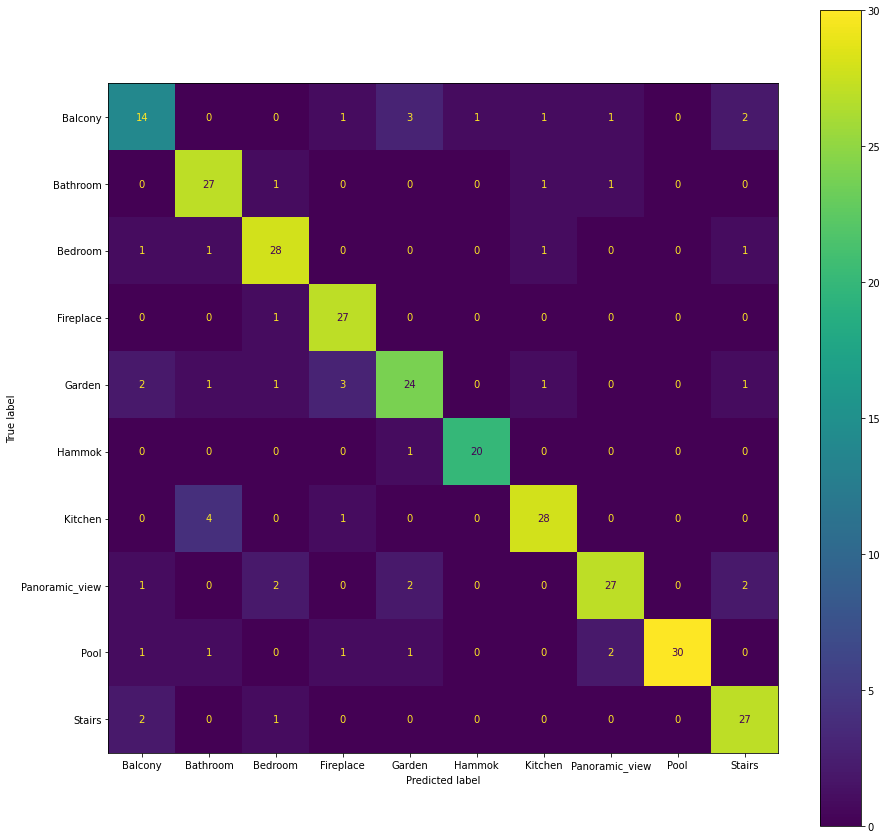

In [19]:
import matplotlib.pyplot as plt
displ = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(15,15))
displ.plot(ax=ax)